In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from utils.utils import load_data, remove_zero_features, standardize
from utils.utils import generate_oversampled_set, generate_undersampled_set, generate_label_stats
from utils.utils import compute_scores_binary

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

In [2]:
plot_path = 'plots/'

In [3]:
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 8


---

In [4]:
# Load data for classification task
subject_data, features, diagnoses = load_data('classification')

In [5]:
# Remove zero features
F = remove_zero_features(features.iloc[:,1:])

In [6]:
# Standardize
X = standardize(F)
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

Number of samples: 2815
Number of features: 922


In [7]:
# Remove ID column
Y = diagnoses.iloc[:,1:]
print(f"Number of labels: {Y.shape[1]}")

Number of labels: 13


In [8]:
boot_iter = 100

---

# 1. Use dataset with original label distribution (no resampling)

In [9]:
label_stats, mean_ir = generate_label_stats(Y, True)
print(f"Mean imbalance ratio: {mean_ir}")
label_stats

Mean imbalance ratio: 7.995236107963529


,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,152,0.053996,11.519737
DepressiveDisorders,300,0.106572,5.836667
Attention_Deficit_HyperactivityDisorder,1751,0.622025,1.000000
MotorDisorder,229,0.081350,7.646288
AutismSpectrumDisorder,398,0.141385,4.399497
CommunicationDisorder,493,0.175133,3.551724
OtherDisorders,135,0.047957,12.970370
SpecificLearningDisorder,761,0.270337,2.300920
Obsessive_Compulsive_And_RelatedDisorders,137,0.048668,12.781022
Disruptive,436,0.154885,4.016055


In [39]:
# Split dataset into train and test (holdout) set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
X_1_test, Y_1_test = X_test, Y_test # for plotting
print(f"Number of samples in training set: {len(X_train)}")
print(f"Number of samples in test set: {len(X_test)}")

Number of samples in training set: 2111
Number of samples in test set: 704


## 1.1. Logistic regression

In [11]:
lr_1_estimators = {}

In [12]:
p_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

gs = GridSearchCV(
    estimator=LogisticRegression(class_weight='balanced', max_iter=10000, random_state=0),
    param_grid=p_grid,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [13]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs.fit(X_train, np.ravel(y_train))

    lr_1_estimators[label] = gs
    print(f"{label}: {gs.best_params_}")

Trauma_And_Stress_RelatedDisorders: {'C': 0.0001}
DepressiveDisorders: {'C': 0.0001}
Attention_Deficit_HyperactivityDisorder: {'C': 0.0001}
MotorDisorder: {'C': 0.0001}
AutismSpectrumDisorder: {'C': 0.0001}
CommunicationDisorder: {'C': 0.0001}
OtherDisorders: {'C': 0.0001}
SpecificLearningDisorder: {'C': 0.001}
Obsessive_Compulsive_And_RelatedDisorders: {'C': 0.001}
Disruptive: {'C': 0.0001}
IntellectualDisability: {'C': 0.001}
EliminationDisorder: {'C': 0.0001}
AnxietyDisorders: {'C': 0.0001}


In [14]:
compute_scores_binary(lr_1_estimators, X_test, Y_test, boot_iter)

Mean scores with SE and 95% confidence intervals:

auprc_macro:                  0.20 (0.01) [0.19, 0.22]
auprc_weighted:               0.34 (0.01) [0.32, 0.36]
auroc_macro:                  0.54 (0.01) [0.52, 0.56]
auroc_weighted:               0.53 (0.01) [0.51, 0.55]
brier_macro:                  0.25 (0.00) [0.25, 0.25]
brier_weighted:               0.04 (0.00) [0.04, 0.04]
balanced_accuracy_macro:      0.53 (0.01) [0.51, 0.55]
balanced_accuracy_weighted:   0.09 (0.00) [0.08, 0.09]
f1_micro:                     0.27 (0.01) [0.25, 0.28]
hamming:                      0.49 (0.01) [0.47, 0.52]
subset_accuracy:              0.07 (0.01) [0.05, 0.09]


## 1.2. Histogram-based Gradient Boosting

In [16]:
hgb_1_estimators = {}

In [19]:
p_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_iter": [100, 200] ,
    "l2_regularization": [0.001, 0.01, 0.1],
}

gs = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=0),
    param_grid=p_grid,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [ ]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs.fit(X_train, np.ravel(y_train))

    hgb_1_estimators[label] = gs
    print(f"{label}: {gs.best_params_}")

In [ ]:
compute_scores_binary(hgb_1_estimators, X_test, Y_test, boot_iter)

# 2. Use undersampled dataset

In [9]:
X_under, Y_under = generate_undersampled_set(X, Y)
label_stats, mean_ir = generate_label_stats(Y_under, True)
print(f"Mean imbalance ratio: {mean_ir}")
label_stats

Mean imbalance ratio: 2.7700915195670985


,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,69,0.069277,3.260870
DepressiveDisorders,103,0.103414,2.184466
Attention_Deficit_HyperactivityDisorder,225,0.225904,1.000000
MotorDisorder,68,0.068273,3.308824
AutismSpectrumDisorder,117,0.117470,1.923077
CommunicationDisorder,105,0.105422,2.142857
OtherDisorders,55,0.055221,4.090909
SpecificLearningDisorder,177,0.177711,1.271186
Obsessive_Compulsive_And_RelatedDisorders,52,0.052209,4.326923
Disruptive,103,0.103414,2.184466


In [10]:
# Split dataset into train and test (holdout) set
X_train, X_test, Y_train, Y_test = train_test_split(X_under, Y_under, test_size=0.25, random_state=0)
X_2_test, Y_2_test = X_test, Y_test # for plotting
print(f"Number of samples in training set: {len(X_train)}")
print(f"Number of samples in test set: {len(X_test)}")

Number of samples in training set: 747
Number of samples in test set: 249


## 2.1. Logistic regression

In [11]:
lr_2_estimators = {}

In [12]:
p_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

gs = GridSearchCV(
    estimator=LogisticRegression(max_iter=10000, random_state=0),
    param_grid=p_grid,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [13]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs.fit(X_train, np.ravel(y_train))

    lr_2_estimators[label] = gs
    print(f"{label}: {gs.best_params_}")

Trauma_And_Stress_RelatedDisorders: {'C': 0.01}
DepressiveDisorders: {'C': 0.0001}
Attention_Deficit_HyperactivityDisorder: {'C': 0.01}
MotorDisorder: {'C': 0.001}
AutismSpectrumDisorder: {'C': 0.001}
CommunicationDisorder: {'C': 0.01}
OtherDisorders: {'C': 0.001}
SpecificLearningDisorder: {'C': 0.01}
Obsessive_Compulsive_And_RelatedDisorders: {'C': 0.0001}
Disruptive: {'C': 10}
IntellectualDisability: {'C': 0.001}
EliminationDisorder: {'C': 10}
AnxietyDisorders: {'C': 0.0001}


In [14]:
compute_scores_binary(lr_2_estimators, X_test, Y_test, boot_iter)

Mean scores with SE and 95% confidence intervals:

auprc_macro:                  0.17 (0.02) [0.14, 0.20]
auprc_weighted:               0.20 (0.02) [0.17, 0.23]
auroc_macro:                  0.57 (0.02) [0.53, 0.61]
auroc_weighted:               0.56 (0.02) [0.52, 0.60]
brier_macro:                  0.10 (0.00) [0.09, 0.11]
brier_weighted:               0.01 (0.00) [0.01, 0.01]
balanced_accuracy_macro:      0.50 (0.00) [0.50, 0.50]
balanced_accuracy_weighted:   0.05 (0.00) [0.05, 0.05]
f1_micro:                     0.00 (0.00) [0.00, 0.00]
hamming:                      0.10 (0.01) [0.09, 0.11]
subset_accuracy:              0.34 (0.03) [0.28, 0.41]


## 2.2. Histogram-based Gradient Boosting

In [15]:
hgb_2_estimators = {}

In [16]:
p_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_iter": [100, 200] ,
    "l2_regularization": [0.001, 0.01, 0.1],
}

gs = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=0),
    param_grid=p_grid,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [17]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs.fit(X_train, np.ravel(y_train))

    hgb_2_estimators[label] = gs
    print(f"{label}: {gs.best_params_}")

Trauma_And_Stress_RelatedDisorders: {'l2_regularization': 0.01, 'learning_rate': 0.05, 'max_iter': 100}
DepressiveDisorders: {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_iter': 200}
Attention_Deficit_HyperactivityDisorder: {'l2_regularization': 0.1, 'learning_rate': 0.01, 'max_iter': 200}
MotorDisorder: {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_iter': 100}
AutismSpectrumDisorder: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_iter': 200}
CommunicationDisorder: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_iter': 100}
OtherDisorders: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_iter': 100}
SpecificLearningDisorder: {'l2_regularization': 0.01, 'learning_rate': 0.05, 'max_iter': 100}
Obsessive_Compulsive_And_RelatedDisorders: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_iter': 200}
Disruptive: {'l2_regularization': 0.001, 'learning_rate': 0.1, 'max_iter': 100}
IntellectualDisability: {'l2_regularization': 0.1, 'learning_rate': 0.1,

In [18]:
compute_scores_binary(hgb_2_estimators, X_test, Y_test, boot_iter)

Mean scores with SE and 95% confidence intervals:

auprc_macro:                  0.14 (0.01) [0.12, 0.16]
auprc_weighted:               0.17 (0.02) [0.14, 0.20]
auroc_macro:                  0.53 (0.02) [0.49, 0.58]
auroc_weighted:               0.53 (0.02) [0.49, 0.57]
brier_macro:                  0.11 (0.01) [0.09, 0.12]
brier_weighted:               0.01 (0.00) [0.01, 0.01]
balanced_accuracy_macro:      0.50 (0.01) [0.48, 0.50]
balanced_accuracy_weighted:   0.05 (0.00) [0.05, 0.05]
f1_micro:                     0.05 (0.02) [0.01, 0.07]
hamming:                      0.13 (0.01) [0.11, 0.15]
subset_accuracy:              0.33 (0.03) [0.28, 0.40]


# 3. Use undersampled dataset

In [32]:
X_over, Y_over = generate_oversampled_set(X, Y)
label_stats, mean_ir = generate_label_stats(Y_over, True)
print(f"Mean imbalance ratio: {mean_ir}")
label_stats

Mean imbalance ratio: 1.6092872677464145


,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,2580,0.116174,1.923256
DepressiveDisorders,3170,0.142741,1.565300
Attention_Deficit_HyperactivityDisorder,4582,0.206322,1.082933
MotorDisorder,3134,0.141120,1.583280
AutismSpectrumDisorder,3689,0.166111,1.345080
CommunicationDisorder,4431,0.199523,1.119838
OtherDisorders,2320,0.104467,2.138793
SpecificLearningDisorder,4962,0.223433,1.000000
Obsessive_Compulsive_And_RelatedDisorders,2668,0.120137,1.859820
Disruptive,2801,0.126126,1.771510


In [40]:
# Split dataset into train and test (holdout) set
X_train, X_test, Y_train, Y_test = train_test_split(X_over, Y_over, test_size=0.25, random_state=0)
X_3_test, Y_3_test = X_test, Y_test # for plotting
print(f"Number of samples in training set: {len(X_train)}")
print(f"Number of samples in test set: {len(X_test)}")

Number of samples in training set: 16656
Number of samples in test set: 5552


## 3.1. Logistic regression

In [34]:
lr_3_estimators = {}

In [35]:
p_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

gs = GridSearchCV(
    estimator=LogisticRegression(max_iter=10000, random_state=0),
    param_grid=p_grid,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [ ]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs.fit(X_train, np.ravel(y_train))

    lr_3_estimators[label] = gs
    print(f"{label}: {gs.best_params_}")

In [ ]:
compute_scores_binary(lr_3_estimators, X_test, Y_test, boot_iter)

Mean scores with SE and 95% confidence intervals:

auprc_macro:                  0.17 (0.02) [0.14, 0.20]
auprc_weighted:               0.20 (0.02) [0.17, 0.23]
auroc_macro:                  0.57 (0.02) [0.53, 0.61]
auroc_weighted:               0.56 (0.02) [0.52, 0.60]
brier_macro:                  0.10 (0.00) [0.09, 0.11]
brier_weighted:               0.01 (0.00) [0.01, 0.01]
balanced_accuracy_macro:      0.50 (0.00) [0.50, 0.50]
balanced_accuracy_weighted:   0.05 (0.00) [0.05, 0.05]
f1_micro:                     0.00 (0.00) [0.00, 0.00]
hamming:                      0.10 (0.01) [0.09, 0.11]
subset_accuracy:              0.34 (0.03) [0.28, 0.41]


## 3.2. Histogram-based Gradient Boosting

In [ ]:
hgb_3_estimators = {}

In [ ]:
p_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_iter": [100, 200] ,
    "l2_regularization": [0.001, 0.01, 0.1],
}

gs = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=0),
    param_grid=p_grid,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [ ]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs.fit(X_train, np.ravel(y_train))

    hgb_3_estimators[label] = gs
    print(f"{label}: {gs.best_params_}")

In [ ]:
compute_scores_binary(hgb_3_estimators, X_test, Y_test, boot_iter)

# 4. Plot PR curve

## 4.1.

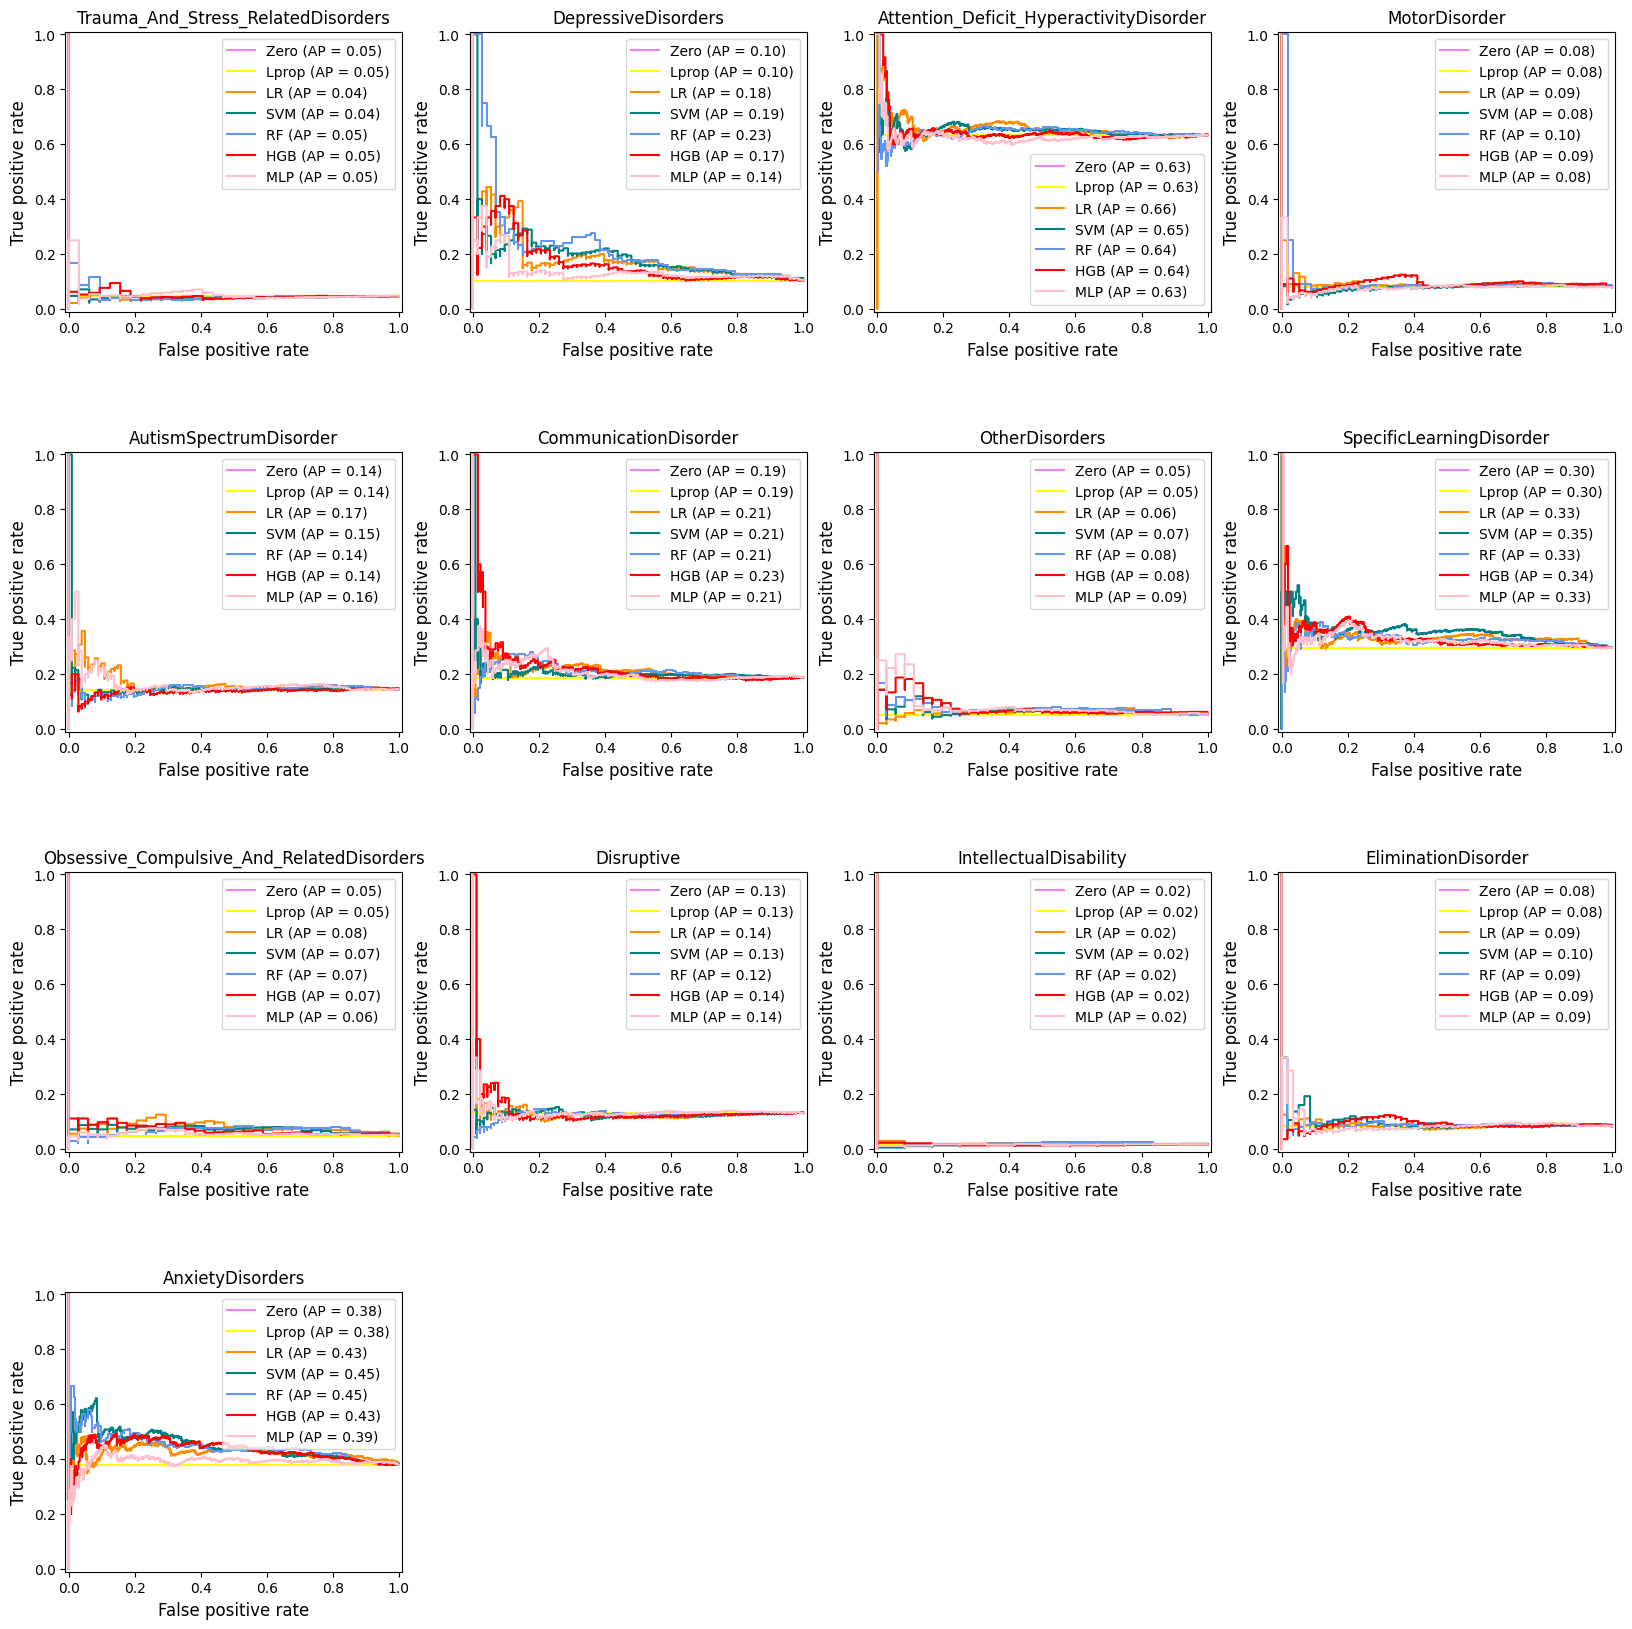

In [ ]:
fig, axs = plt.subplots(4,4, figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

counter = 0
for i in range(0,4,1):
    for j in range(0,4,1):
        if (i > 2 & j > 0) or (counter > 12):
            fig.delaxes(axs[i,j])
        else:
            label = Y_1_test.columns[counter]
            counter += 1
            
            y_prob_lr = lr_1_estimators[label].predict_proba(X_1_test)[:, 1] 
            y_prob_hgb = hgb_1_estimators[label].predict_proba(X_1_test)[:, 1]
            
            disp3 = PrecisionRecallDisplay.from_predictions(Y_1_test[label], y_prob_lr, pos_label=1, name="LR", ax=axs[i,j], color="darkorange")
            disp4 = PrecisionRecallDisplay.from_predictions(Y_1_test[label], y_prob_hgb, pos_label=1, name="HGB", ax=axs[i,j], color="teal")
            
            axs[i,j].set_title(f"{label}")
            axs[i,j].legend(loc="best")
            axs[i,j].set_xlabel("Recall", size=12)
            axs[i,j].set_ylabel("Precision", size=12)
            axs[i,j].set_xmargin(0.01)
            axs[i,j].set_ymargin(0.01)

## 4.2.

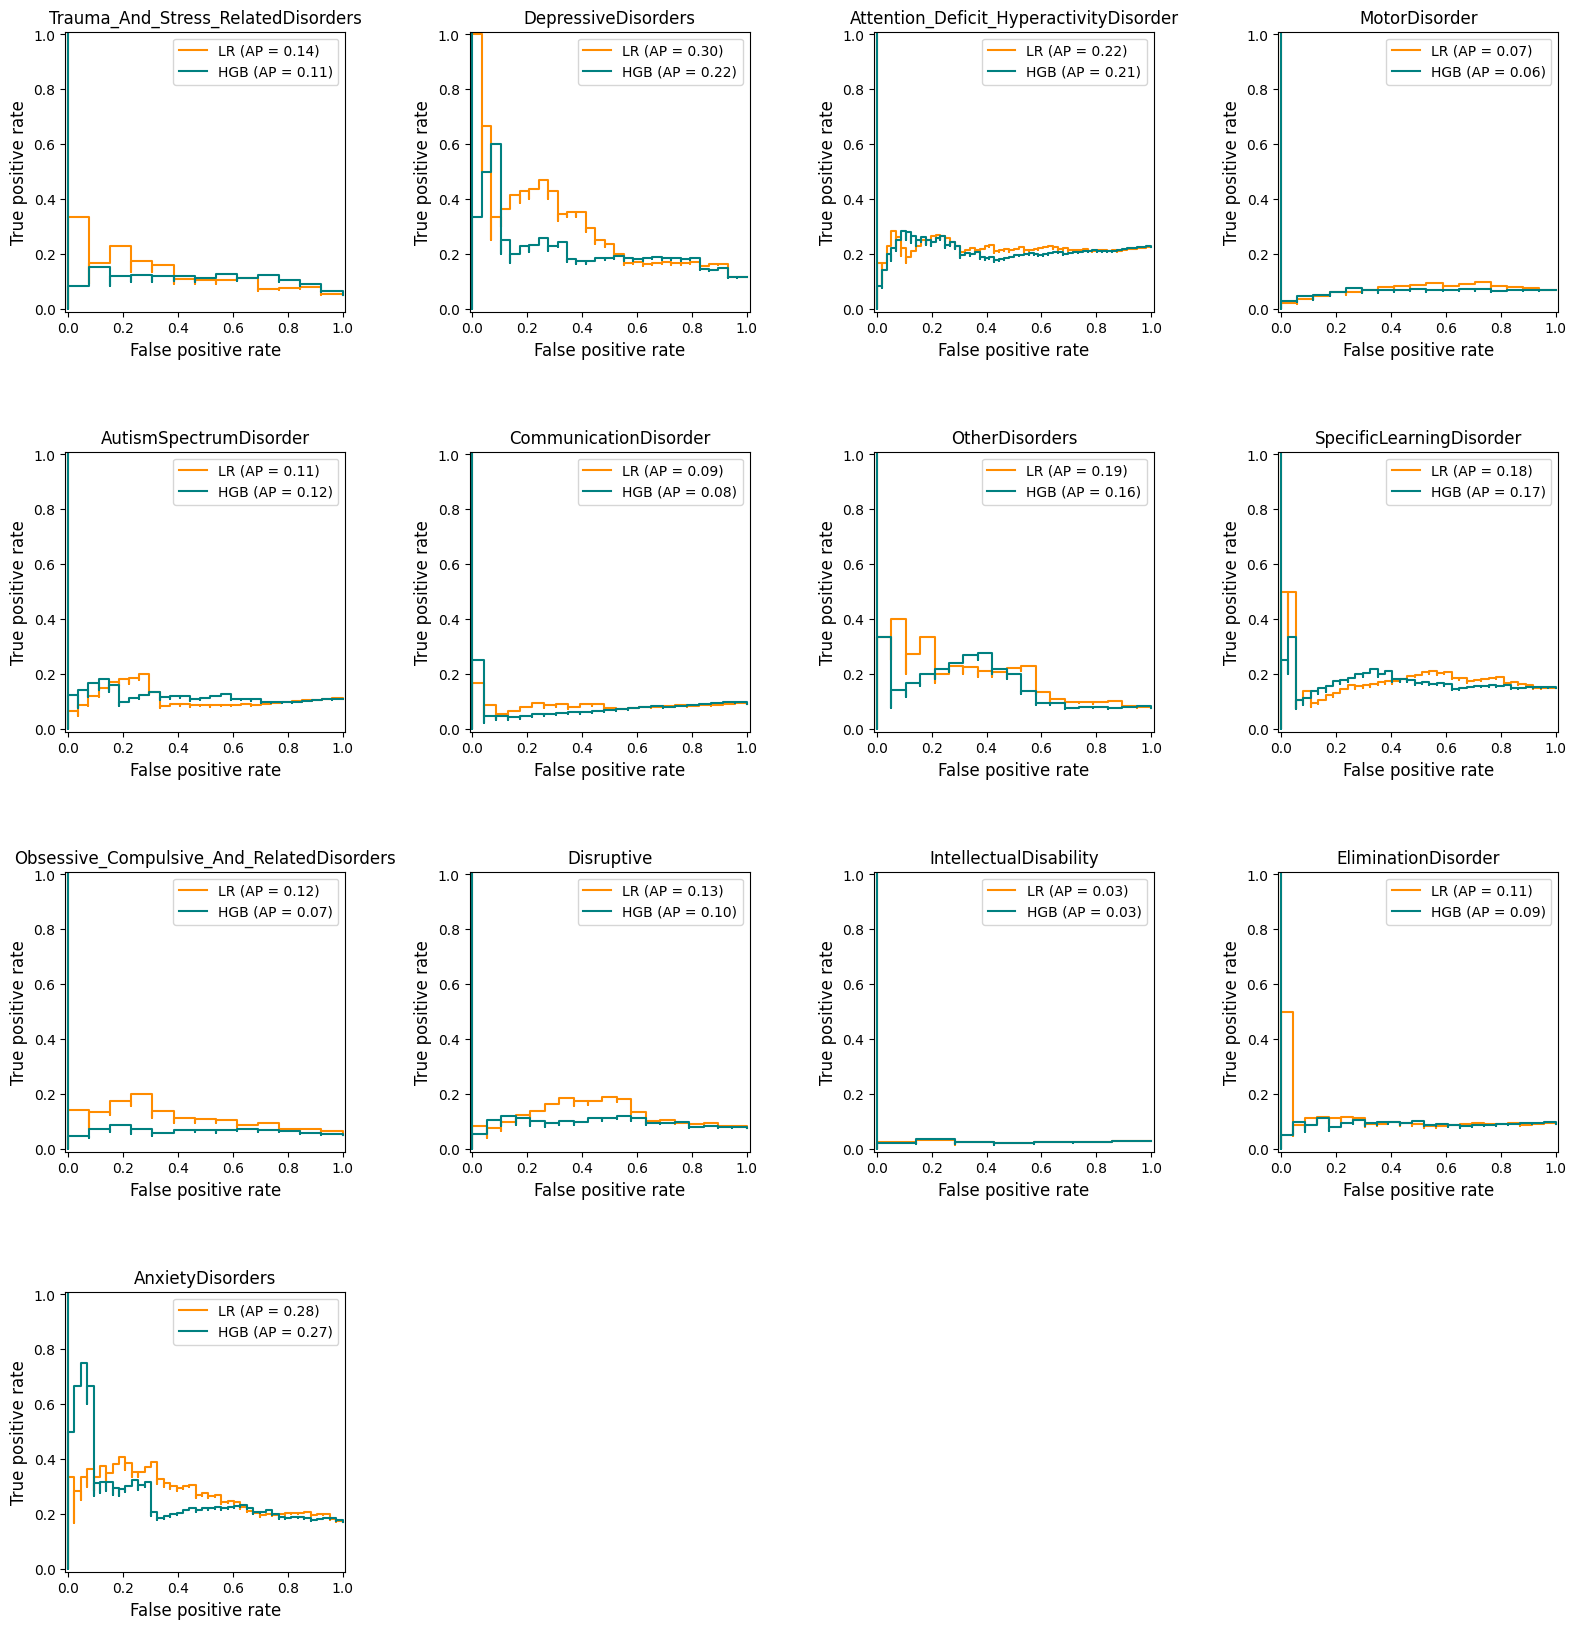

In [19]:
fig, axs = plt.subplots(4,4, figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

counter = 0
for i in range(0,4,1):
    for j in range(0,4,1):
        if (i > 2 & j > 0) or (counter > 12):
            fig.delaxes(axs[i,j])
        else:
            label = Y_2_test.columns[counter]
            counter += 1
            
            y_prob_lr = lr_2_estimators[label].predict_proba(X_2_test)[:, 1] 
            y_prob_hgb = hgb_2_estimators[label].predict_proba(X_2_test)[:, 1]
            
            disp3 = PrecisionRecallDisplay.from_predictions(Y_2_test[label], y_prob_lr, pos_label=1, name="LR", ax=axs[i,j], color="darkorange")
            disp4 = PrecisionRecallDisplay.from_predictions(Y_2_test[label], y_prob_hgb, pos_label=1, name="HGB", ax=axs[i,j], color="teal")
            
            axs[i,j].set_title(f"{label}")
            axs[i,j].legend(loc="best")
            axs[i,j].set_xlabel("Recall", size=12)
            axs[i,j].set_ylabel("Precision", size=12)
            axs[i,j].set_xmargin(0.01)
            axs[i,j].set_ymargin(0.01)

## 4.3.

In [ ]:
fig, axs = plt.subplots(4,4, figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

counter = 0
for i in range(0,4,1):
    for j in range(0,4,1):
        if (i > 2 & j > 0) or (counter > 12):
            fig.delaxes(axs[i,j])
        else:
            label = Y_3_test.columns[counter]
            counter += 1
            
            y_prob_lr = lr_3_estimators[label].predict_proba(X_3_test)[:, 1] 
            y_prob_hgb = hgb_3_estimators[label].predict_proba(X_3_test)[:, 1]
            
            disp3 = PrecisionRecallDisplay.from_predictions(Y_3_test[label], y_prob_lr, pos_label=1, name="LR", ax=axs[i,j], color="darkorange")
            disp4 = PrecisionRecallDisplay.from_predictions(Y_3_test[label], y_prob_hgb, pos_label=1, name="HGB", ax=axs[i,j], color="teal")
            
            axs[i,j].set_title(f"{label}")
            axs[i,j].legend(loc="best")
            axs[i,j].set_xlabel("Recall", size=12)
            axs[i,j].set_ylabel("Precision", size=12)
            axs[i,j].set_xmargin(0.01)
            axs[i,j].set_ymargin(0.01)

# 5. Plot ROC curve

## 5.1.

In [ ]:
fig, axs = plt.subplots(4,4, figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

counter = 0
for i in range(0,4,1):
    for j in range(0,4,1):
        if (i > 2 & j > 0) or (counter > 12):
            fig.delaxes(axs[i,j])
        else:
            label = Y_1_test.columns[counter]
            counter += 1
            
            y_prob_lr = lr_1_estimators[label].predict_proba(X_1_test)[:, 1] 
            y_prob_hgb = hgb_1_estimators[label].predict_proba(X_1_test)[:, 1]
            
            disp3 = RocCurveDisplay.from_predictions(Y_1_test[label], y_prob_lr, pos_label=1, name="LR", ax=axs[i,j], color="darkorange")
            disp4 = RocCurveDisplay.from_predictions(Y_1_test[label], y_prob_hgb, pos_label=1, name="HGB", ax=axs[i,j], color="teal")
            
            axs[i,j].set_title(f"{label}")
            axs[i,j].legend(loc="best")
            axs[i,j].set_xlabel("False positive rate", size=12)
            axs[i,j].set_ylabel("True positive rate", size=12)
            axs[i,j].set_xmargin(0.01)
            axs[i,j].set_ymargin(0.01)

## 5.2.

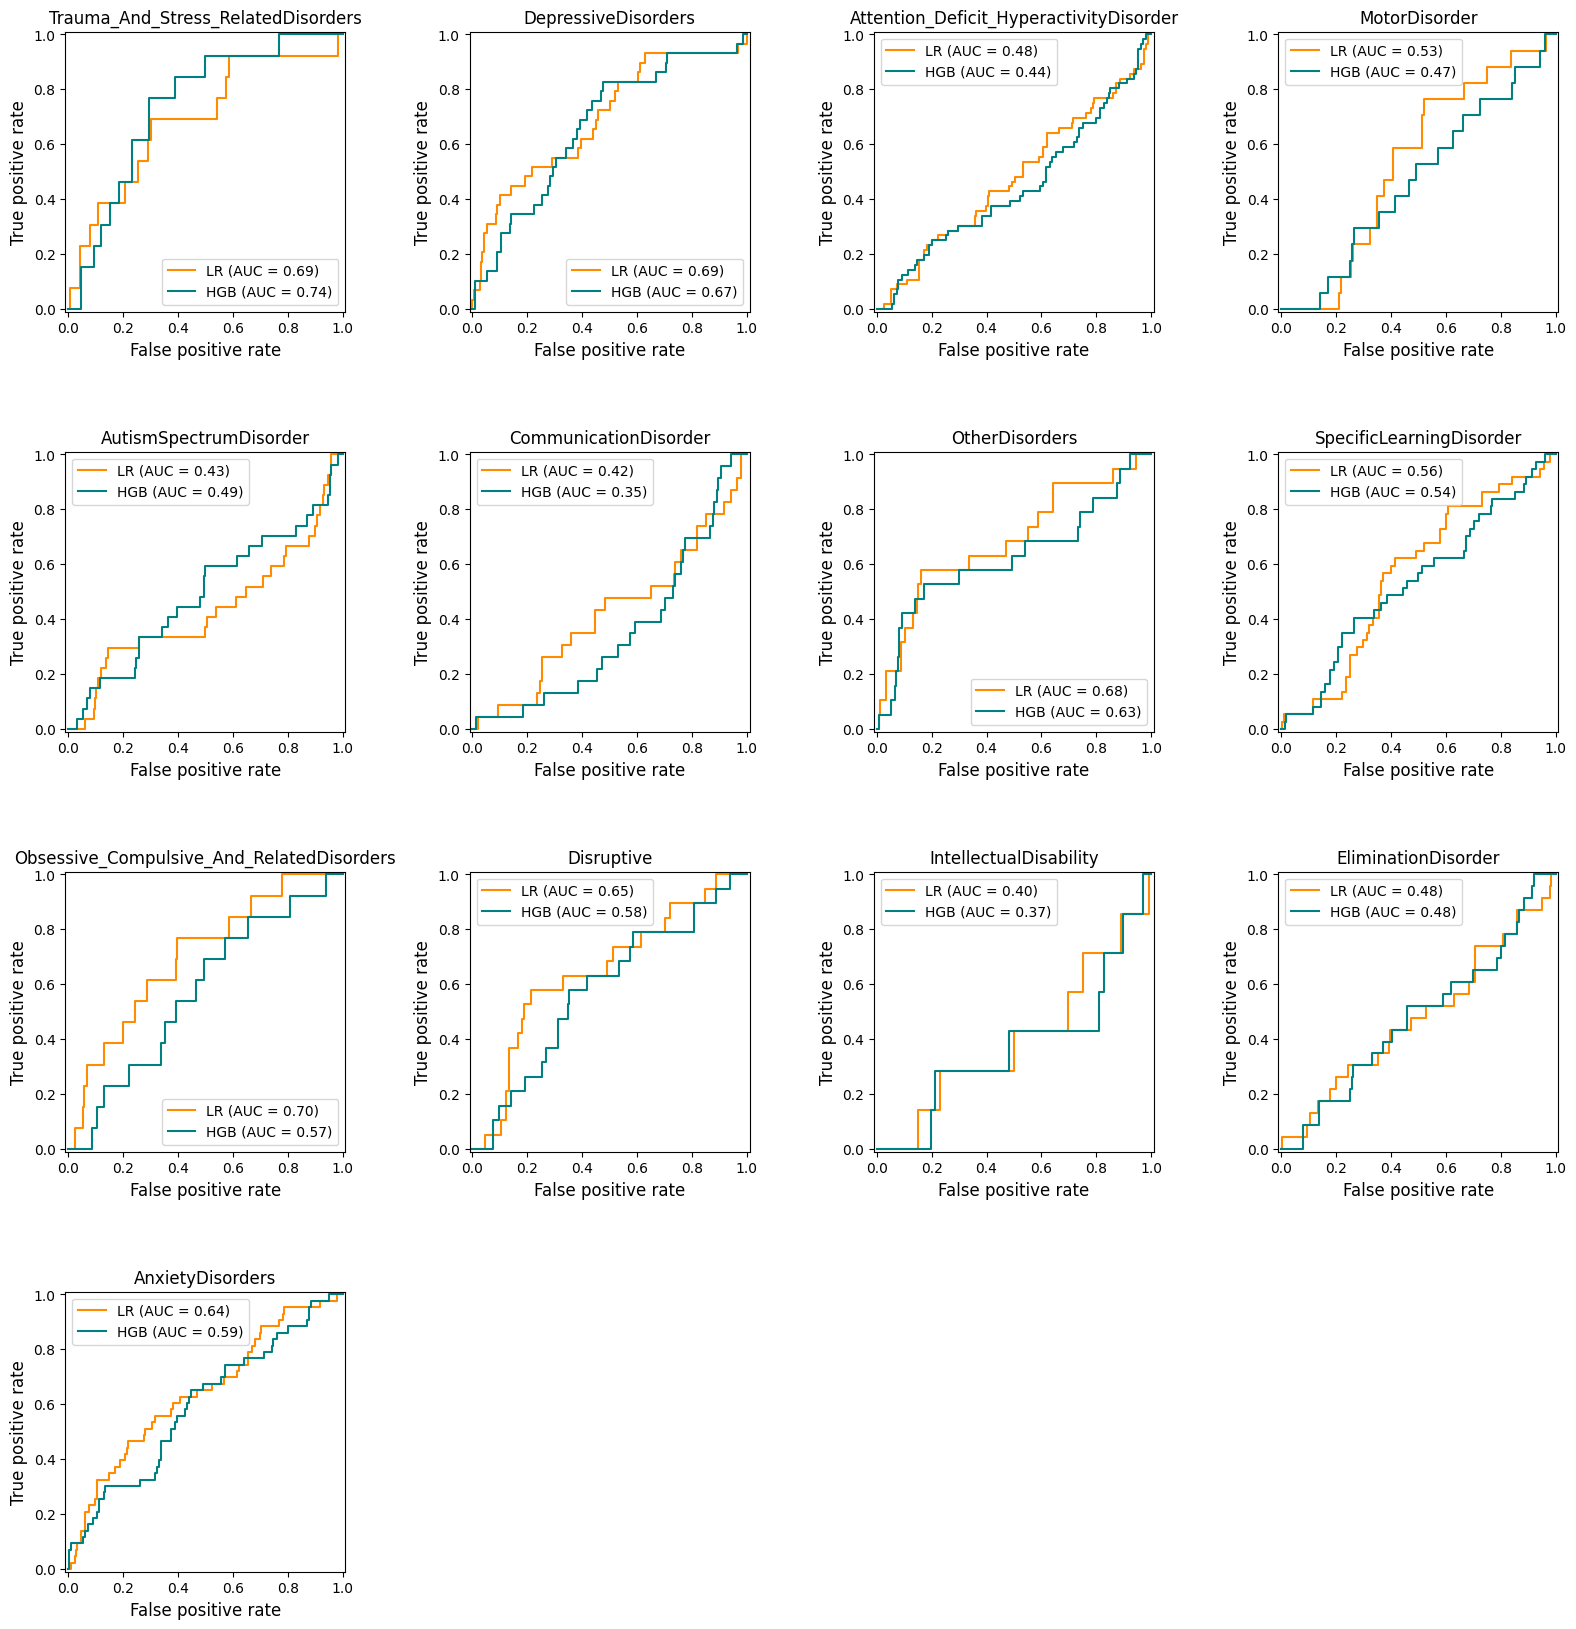

In [20]:
fig, axs = plt.subplots(4,4, figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

counter = 0
for i in range(0,4,1):
    for j in range(0,4,1):
        if (i > 2 & j > 0) or (counter > 12):
            fig.delaxes(axs[i,j])
        else:
            label = Y_2_test.columns[counter]
            counter += 1
            
            y_prob_lr = lr_2_estimators[label].predict_proba(X_2_test)[:, 1] 
            y_prob_hgb = hgb_2_estimators[label].predict_proba(X_2_test)[:, 1]
            
            disp3 = RocCurveDisplay.from_predictions(Y_2_test[label], y_prob_lr, pos_label=1, name="LR", ax=axs[i,j], color="darkorange")
            disp4 = RocCurveDisplay.from_predictions(Y_2_test[label], y_prob_hgb, pos_label=1, name="HGB", ax=axs[i,j], color="teal")
            
            axs[i,j].set_title(f"{label}")
            axs[i,j].legend(loc="best")
            axs[i,j].set_xlabel("False positive rate", size=12)
            axs[i,j].set_ylabel("True positive rate", size=12)
            axs[i,j].set_xmargin(0.01)
            axs[i,j].set_ymargin(0.01)

## 5.3.

In [ ]:
fig, axs = plt.subplots(4,4, figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

counter = 0
for i in range(0,4,1):
    for j in range(0,4,1):
        if (i > 2 & j > 0) or (counter > 12):
            fig.delaxes(axs[i,j])
        else:
            label = Y_3_test.columns[counter]
            counter += 1
            
            y_prob_lr = lr_3_estimators[label].predict_proba(X_3_test)[:, 1] 
            y_prob_hgb = hgb_3_estimators[label].predict_proba(X_3_test)[:, 1]
            
            disp3 = RocCurveDisplay.from_predictions(Y_3_test[label], y_prob_lr, pos_label=1, name="LR", ax=axs[i,j], color="darkorange")
            disp4 = RocCurveDisplay.from_predictions(Y_3_test[label], y_prob_hgb, pos_label=1, name="HGB", ax=axs[i,j], color="teal")
            
            axs[i,j].set_title(f"{label}")
            axs[i,j].legend(loc="best")
            axs[i,j].set_xlabel("False positive rate", size=12)
            axs[i,j].set_ylabel("True positive rate", size=12)
            axs[i,j].set_xmargin(0.01)
            axs[i,j].set_ymargin(0.01)